# Example: Using the PD Simulator for Mortgage Portfolio

This notebook demonstrates how to use the `pd_simulator.py` module from the `irbstudio.simulation` package to simulate Probability of Default (PD) for a mortgage portfolio.

We will:
1. Import required libraries
2. Import the `pd_simulator` module
3. Generate a realistic mortgage portfolio dataset (5000+ facilities with 36-month history)
4. Run the simulation using the `pd_simulator` module
5. Visualize the results

## 1. Import Required Libraries

We will use pandas for data manipulation and matplotlib for visualization. If you want interactive plots, you can also use plotly.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: import plotly.express as px for interactive plots

# Set matplotlib to display plots inline
%matplotlib inline

## 2. Import pd_simulator Module

We import the `pd_simulator` module from the `irbstudio.simulation` package. If running outside the package root, you may need to adjust the Python path.

In [22]:
from irbstudio.simulation import pd_simulator

## 3. Load Mortgage Portfolio Dataset

We will load the sample portfolio data from the `sample_portfolio_data.csv` file. This file should be generated first by running the `examples/sample_data.py` script.

The dataset contains the following key columns:
- `facility_id`: Unique identifier for each mortgage.
- `observation_date`: The month of the observation.
- `exposure`: The outstanding principal amount.
- `rating`: The assigned credit rating for that month.
- `score`: A risk score, where a higher score indicates a higher probability of default (PD).
- `default_flag`: A flag indicating if the facility is in default.
- `into_default_flag`: A forward-looking flag indicating if the facility will default within the next 12 months.

In [37]:
# Load the dataset from the CSV file generated by `examples/sample_data.py`
# The path is relative to the notebook's location in the `notebooks` directory.
try:
    portfolio_df = pd.read_csv('../data/sample_portfolio_data.csv', parse_dates=['observation_date'])
    print("Successfully loaded `sample_portfolio_data.csv`.")
except FileNotFoundError:
    print("Error: `sample_portfolio_data.csv` not found.")
    print("Please run the `examples/sample_data.py` script first to generate the data.")
    portfolio_df = pd.DataFrame()

if not portfolio_df.empty:
    # Display info
    latest_observations = portfolio_df.sort_values('observation_date').groupby('facility_id').last()
    default_rate = (latest_observations['rating'] == 'D').mean()
    
    print(f"\nTotal facilities: {portfolio_df['facility_id'].nunique()}")
    print(f"Total observations: {len(portfolio_df)}")
    print(f"Date range: {portfolio_df['observation_date'].min().date()} to {portfolio_df['observation_date'].max().date()}")
    print(f"Current default rate: {default_rate:.4f} ({default_rate*100:.2f}%)")
    
    print("\nRating distribution (latest observation for each facility):")
    print(latest_observations['rating'].value_counts().sort_index())
    
    print("\nPortfolio characteristics:")
    print(latest_observations[['exposure', 'score']].describe())
    
    print("\nSample data:")
    print(portfolio_df.head())

Successfully loaded `sample_portfolio_data.csv`.

Total facilities: 20000
Total observations: 1280027
Date range: 2015-01-31 to 2025-12-31
Current default rate: 0.0508 (5.08%)

Rating distribution (latest observation for each facility):
rating
1    10632
2     1395
3      919
4     1277
5     1303
6     1236
7     1055
8      819
9      349
D     1015
Name: count, dtype: int64

Portfolio characteristics:
            exposure         score
count   20000.000000  20000.000000
mean   425063.342355      0.223353
std    235926.565249      0.317883
min     23203.537374      0.010000
25%    223857.636553      0.010000
50%    409783.423546      0.035743
75%    610156.678259      0.333662
max    985336.963574      1.000000

Sample data:
  facility_id observation_date       exposure  default_flag  \
0   FAC_00000       2016-08-31  110606.503961             0   
1   FAC_00000       2016-09-30  110062.467719             0   
2   FAC_00000       2016-10-31  109518.431477             0   
3   FAC_000

## 4. Run PD Simulation

Now we'll configure the PD simulation and run it using the `pd_simulator` module. We'll set up the simulation parameters based on our mortgage portfolio characteristics.

In [19]:
df_filtered.columns

Index(['Loan_Sequence_Number', 'reporting_date', 'Current_Actual_UPB',
       'rating', 'score', 'default_flag', 'into_default_flag'],
      dtype='object')

In [37]:

# Define the score-to-rating boundaries based on the logic in sample_data.py
# These are used to map the output `simulated_pd` back to a `simulated_rating`.
# The keys are ratings, values are (lower_bound, upper_bound) of the PD.
# score_to_rating_bounds = {
#     '1': (0.00, 0.05),
#     '2': (0.05, 0.10),
#     '3': (0.10, 0.15),
#     '4': (0.15, 0.25),
#     '5': (0.25, 0.40),
#     '6': (0.40, 0.60),
#     '7': (0.60, 0.80),
#     '8': (0.80, 0.95),
#     '9': (0.95, 1.01)
# }
portfolio_df = pd.read_csv('../data/sample_portfolio_data_fm.csv')
score_to_rating_bounds = {'1': (-1,0.003613294451497495),
    '2': (0.003613294451497495,0.005780360195785761),
    '3': (0.005780360195785761,0.03225071728229523),
    '4': (0.03225071728229523,0.039578670635819435),
    '5': (0.039578670635819435,0.256146103143692),
    '6': (0.256146103143692,0.7653337121009827),
    '7': (0.7653337121009827,50)}

    

# Run the PD simulation using the actual pd_simulator module
print("Running PD simulation for the loaded portfolio...")

if not portfolio_df.empty:
    try:
        result_df = pd_simulator.simulate_portfolio(
            portfolio_df=portfolio_df,
            score_to_rating_bounds=score_to_rating_bounds,
            rating_col='rating',
            loan_id_col='Loan_Sequence_Number',
            date_col='reporting_date',
            default_col='default_flag',
            into_default_flag_col='into_default_flag',
            score_col='score',
            asset_correlation=0.15,
            target_auc=0.90,  # Optional: target AUC for new client scores
        )

        # Display summary statistics
        print(f"\nTotal observations in simulation output: {len(result_df)}")
        print(f"Number of unique facilities: {result_df['facility_id'].nunique()}")
        print(f"Simulated date range: {result_df['observation_date'].min().date()} to {result_df['observation_date'].max().date()}")
        
        # Show a sample of the simulation results, including new columns
        print("\nSample of simulation results:")
        print(result_df[['facility_id', 'observation_date', 'rating', 'simulated_rating', 'simulated_pd']].head())

    except Exception as e:
        print(f"\nAn error occurred during simulation: {e}")
        print("Please ensure the `pd_simulator.py` module is correctly implemented and all required columns are present.")
        result_df = pd.DataFrame() # Create empty df to avoid breaking downstream cells
else:
    print("Portfolio DataFrame is empty. Skipping simulation.")
    result_df = pd.DataFrame()

Running PD simulation for the loaded portfolio...
2025-09-16 16:52:18 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-16 16:52:18 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=2.36, beta=431.43, weight=0.99
2025-09-16 16:52:18 - irbstudio.simulation.distribution - INFO - Default (C1): alpha=0.34, beta=4.50, weight=0.01
2025-09-16 16:52:18 - irbstudio.simulation.score_generation - INFO - Searching for gamma to achieve target AUC of 0.9...
2025-09-16 16:52:18 - irbstudio.simulation.score_generation - INFO - Found calibrated gamma of 1.1265.
2025-09-16 16:52:18 - irbstudio.simulation.distribution - INFO - Applied AUC calibration with gamma=1.126 for target AUC 0.900
2025-09-16 16:52:18 - irbstudio.simulation.score_generation - INFO - Searching for gamma to achieve target AUC of 0.9...
2025-09-16 16:52:18 - irbstudio.simulation.score_generation - INFO - Found calibrated gamma of 1.1264.
2025-09-16 16:52:18 - irbstudio.simulation.dist

C:\Users\jacek\Desktop\Projects\IRBStudio\irbstudio\simulation\pd_simulator.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['idiosyncratic_score'] = np.nan



An error occurred during simulation: Unable to allocate 185. MiB for an array with shape (4, 6069488) and data type float64
Please ensure the `pd_simulator.py` module is correctly implemented and all required columns are present.


In [27]:
result_df = pd.read_csv('../data/simulated_portfolio.csv')

C:\Users\jacek\AppData\Local\Temp\ipykernel_6052\3246410146.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  result_df = pd.read_csv('../data/simulated_portfolio.csv')


In [28]:
result_df.groupby('rating')['simulated_rating'].value_counts().unstack().fillna(0).round(2)

simulated_rating,1,2,3,5,6,5,6,D
rating,,,,,,,,
1,8.0,0.0,0.0,3730776.0,4243.0,0.0,0.0,0.0
2,4758.0,877.0,329.0,2520412.0,7359.0,277.0,0.0,0.0
3,254435.0,45340.0,17091.0,1980643.0,2449.0,11457.0,1.0,0.0
4,1445.0,212.0,110.0,23164.0,323.0,3.0,0.0,0.0
5,1342.0,240.0,109.0,38074.0,762.0,70.0,0.0,0.0
6,257.0,34.0,16.0,13729.0,2138.0,13.0,0.0,38.0
7,12.0,1.0,0.0,62.0,2.0,1.0,0.0,49094.0


In [ ]:
check_df = result_df[result_df['into_default_flag'].notna()]

## 5. Analyze and Visualize Simulation Results

Let's analyze the key results from our mortgage portfolio simulation and create some useful visualizations.

In [40]:
# Perform basic analysis of simulation results, if the simulation was successful
if not result_df.empty:
    # Use the most recent simulated data for analysis
    analysis_df = result_df.sort_values('observation_date').groupby('facility_id').last().reset_index()

    # 1. Analyze rating migration from original to simulated
    migration_matrix = pd.crosstab(
        analysis_df['rating'], 
        analysis_df['simulated_rating'],
        normalize='index'
    )

    print("Rating migration matrix (Original vs. Simulated):")
    print(migration_matrix.round(3))



    # 3. Summarize simulated portfolio quality
    final_default_rate = (analysis_df['simulated_rating'] == 'D').mean()
    print(f"\nFinal simulated default rate: {final_default_rate:.4f} ({final_default_rate*100:.2f}%)")

    # Prepare data for visualization
    visualization_data = {
        'migration_matrix': migration_matrix,
        'rating_transitions': analysis_df[['rating', 'simulated_rating']],
    }
else:
    print("Simulation did not produce results. Skipping analysis.")
    visualization_data = {}

Rating migration matrix (Original vs. Simulated):
simulated_rating      3      4      5      6      7      8    D
rating                                                         
1                 0.410  0.183  0.167  0.131  0.087  0.021  0.0
2                 0.380  0.179  0.185  0.153  0.079  0.024  0.0
3                 0.402  0.180  0.177  0.132  0.081  0.028  0.0
4                 0.377  0.189  0.193  0.131  0.085  0.024  0.0
5                 0.411  0.186  0.172  0.123  0.085  0.023  0.0
6                 0.410  0.180  0.165  0.140  0.077  0.028  0.0
7                 0.394  0.210  0.174  0.126  0.079  0.017  0.0
8                 0.408  0.185  0.153  0.129  0.105  0.020  0.0
9                 0.424  0.209  0.160  0.105  0.078  0.023  0.0
D                 0.000  0.000  0.000  0.000  0.000  0.000  1.0

Final simulated default rate: 0.0508 (5.08%)


C:\Users\jacek\AppData\Local\Temp\ipykernel_16944\2890943954.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(title='PD Type')


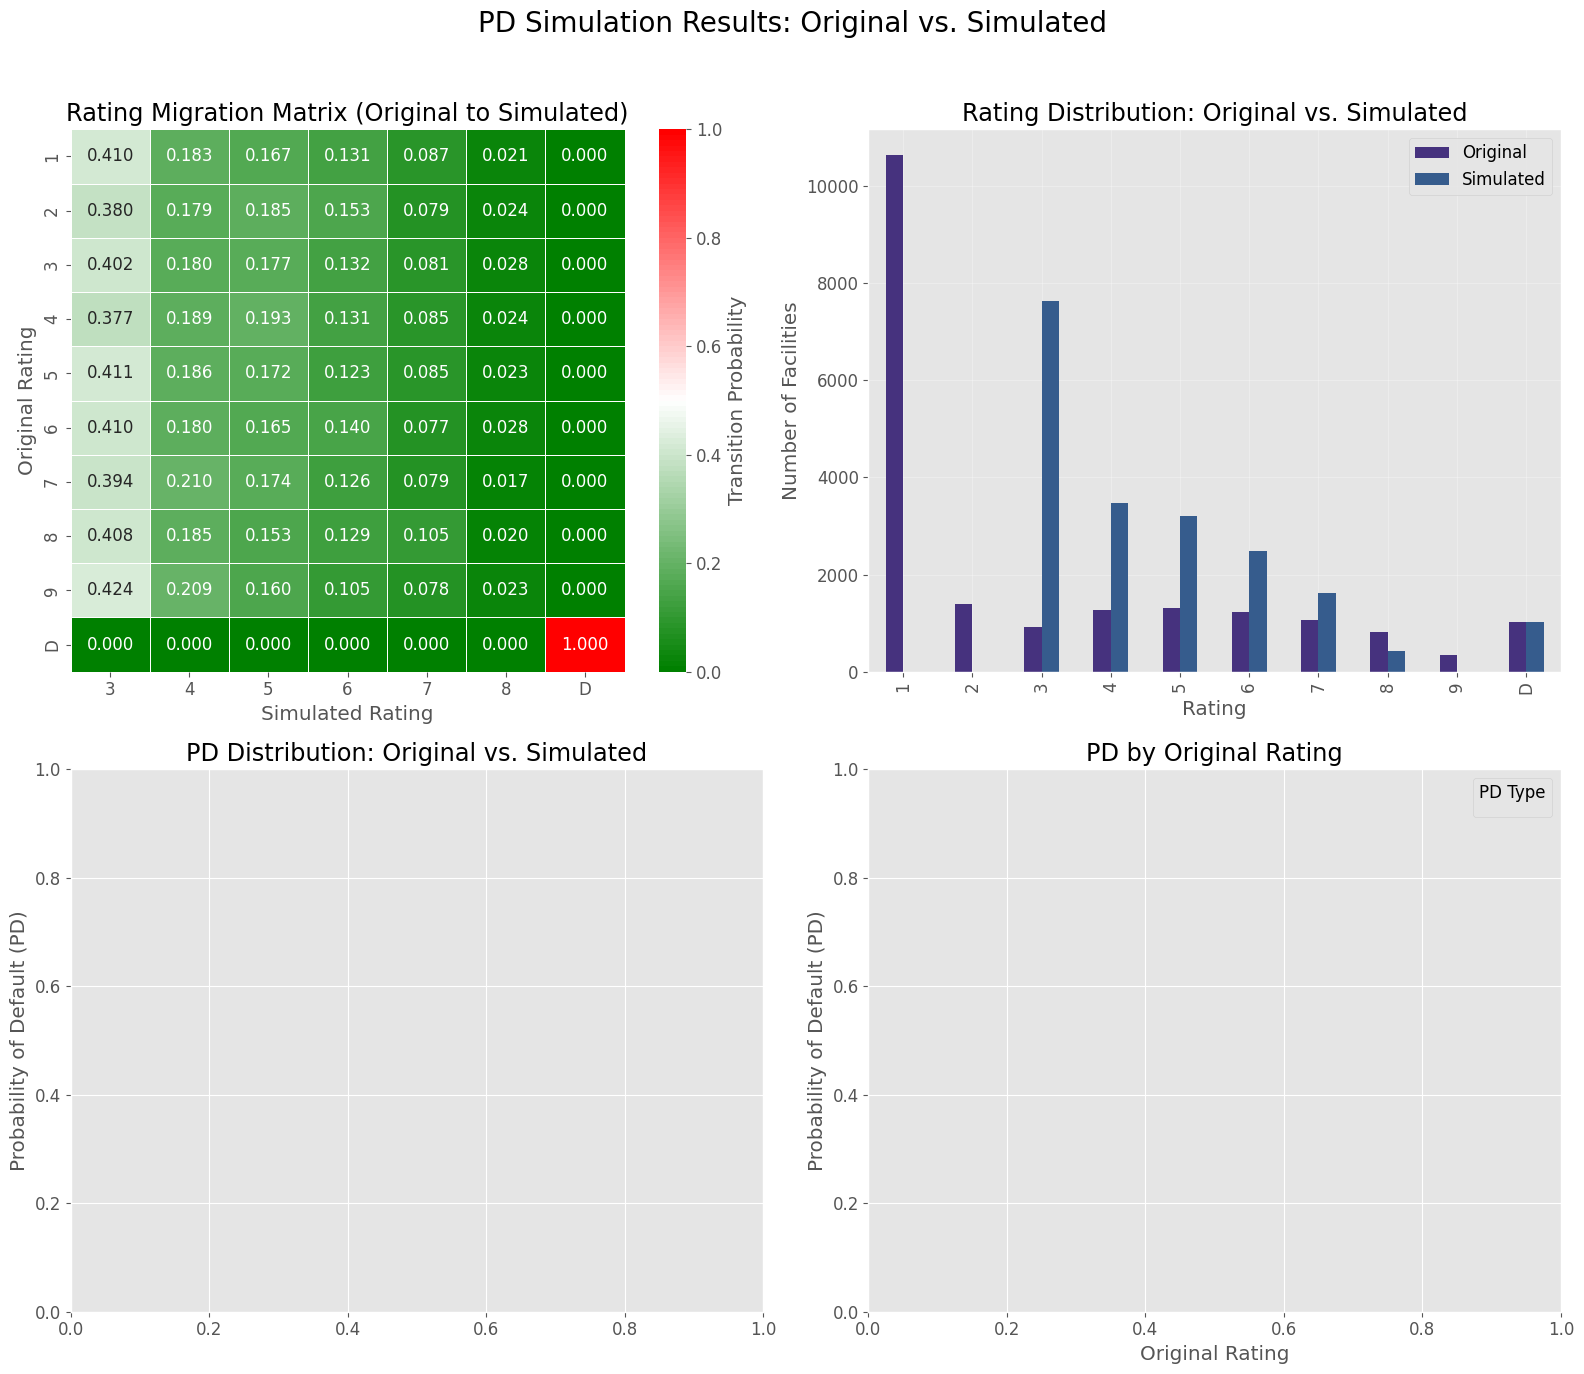

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up a more professional plot style
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

if visualization_data:
    # Create a figure with subplots for key visualizations
    fig = plt.figure(figsize=(16, 14))
    fig.suptitle('PD Simulation Results: Original vs. Simulated', fontsize=20)

    # 1. Heatmap of migration matrix
    ax1 = plt.subplot(2, 2, 1)
    colors = ["green", "white", "red"]
    cm = LinearSegmentedColormap.from_list("custom", colors, N=100)

    def sort_ratings(ratings):
        numeric_ratings = sorted([r for r in ratings if r != 'D'])
        return numeric_ratings + ['D'] if 'D' in ratings else numeric_ratings

    migration_matrix = visualization_data['migration_matrix']
    row_ratings = sort_ratings(migration_matrix.index)
    col_ratings = sort_ratings(migration_matrix.columns)
    sorted_matrix = migration_matrix.reindex(index=row_ratings, columns=col_ratings).fillna(0)

    sns.heatmap(sorted_matrix, cmap=cm, annot=True, fmt='.3f', 
                linewidths=0.5, ax=ax1, vmin=0, vmax=1, cbar_kws={'label': 'Transition Probability'})
    ax1.set_title('Rating Migration Matrix (Original to Simulated)')
    ax1.set_xlabel('Simulated Rating')
    ax1.set_ylabel('Original Rating')

    # 2. Rating distribution before and after simulation
    ax2 = plt.subplot(2, 2, 2)
    rating_transitions = visualization_data['rating_transitions']
    start_counts = rating_transitions['rating'].value_counts().sort_index()
    end_counts = rating_transitions['simulated_rating'].value_counts().sort_index()
    
    rating_counts = pd.DataFrame({'Original': start_counts, 'Simulated': end_counts}).fillna(0)
    sorted_ratings = sort_ratings(rating_counts.index)
    rating_counts = rating_counts.reindex(sorted_ratings)

    rating_counts.plot(kind='bar', ax=ax2)
    ax2.set_title('Rating Distribution: Original vs. Simulated')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Number of Facilities')
    ax2.grid(True, alpha=0.3)

    # 3. PD distribution comparison (violin plot)
    ax3 = plt.subplot(2, 2, 3)

    ax3.set_title('PD Distribution: Original vs. Simulated')
    ax3.set_ylabel('Probability of Default (PD)')

    # 4. PD comparison by original rating
    ax4 = plt.subplot(2, 2, 4)
    pd_full_comparison = analysis_df[['rating', 'simulated_pd']].copy()
    
    
    ax4.set_title('PD by Original Rating')
    ax4.set_xlabel('Original Rating')
    ax4.set_ylabel('Probability of Default (PD)')
    ax4.legend(title='PD Type')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("No data to visualize.")

## Conclusion

This example demonstrates how to use the PD simulator module to model default risk in a mortgage portfolio. The simulation provides valuable insights into:

1. **Default Rates**: The monthly and cumulative default rates across different scenarios.

2. **Rating Migration**: How mortgages transition between rating categories over time.

3. **Risk Factors**: The relationship between LTV ratios and default probability.

4. **Portfolio Quality**: Changes in the overall distribution of ratings from start to end.

These insights can be used for:
- Regulatory capital calculations
- IFRS 9/CECL expected credit loss estimation
- Stress testing
- Mortgage portfolio risk management
- Pricing and underwriting strategy

By using the `pd_simulator` module, financial institutions can efficiently model credit risk in their mortgage portfolios without implementing complex simulation logic from scratch.

In [46]:
df = result_df.loc[(result_df['observation_date'] < pd.Timestamp('2024-12-01')) & (result_df['default_flag'] == 0)]

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(df['into_default_flag'], df['rating'])

0.5477363887671051

In [1]:
from irbstudio.data.loader import FreddieMacLoader

In [2]:
loader = FreddieMacLoader('../data/FM/sample_svcg_*.txt', '../data/FM/sample_orig_*.txt')
df = loader.load_performance()

In [3]:
df['dpd_group'] = df['Current_Loan_Delinquency_Status'].apply(lambda x: int(x) if str(x).isdigit() else 0)
df['default_flag'] = (df['dpd_group'] >= 3)*1

In [4]:
import pandas as pd
df['reporting_date'] = pd.to_datetime(df['Monthly_Reporting_Period'], format='%Y%m') + pd.offsets.MonthEnd(0)

In [5]:
# Create into_default_flag: 1 if facility goes into default within next 12 months, else 0
df = df.sort_values(['Loan_Sequence_Number', 'reporting_date'])
df['into_default_flag'] = (
    df.groupby('Loan_Sequence_Number')['default_flag']
    .transform(lambda x: x.rolling(window=12, min_periods=1).max().shift(-1).fillna(0))
    .astype(int)
)

In [6]:
import numpy as np
# Adjust into_default_flag for facilities with less than 12 months of history
facility_counts = df.groupby('Loan_Sequence_Number')['reporting_date'].count()
short_facilities = facility_counts[facility_counts < 12].index

mask_short = df['Loan_Sequence_Number'].isin(short_facilities)
mask_no_default = (df['into_default_flag'] == 0) & (df['default_flag'] == 0)

df.loc[mask_short & mask_no_default, 'into_default_flag'] = np.nan

In [7]:
# Find the most recent 12 months in the portfolio
latest_months = df['reporting_date'].sort_values(ascending=False).unique()[:12]

# Filter: keep rows where into_default_flag is not NaN,
# or where reporting_date is in the most recent 12 months
df_filtered = df[(~df['into_default_flag'].isna()) | (df['reporting_date'].isin(latest_months))]

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Select a sample for quick fitting (e.g., 50,000 rows, stratified by into_default_flag)
sample_df = df_filtered.dropna(subset=['into_default_flag'])
sample_df = sample_df.sample(frac=1, random_state=42)  # Shuffle
sample_df, _ = train_test_split(
    sample_df, 
    train_size=2500, 
    stratify=sample_df['into_default_flag'], 
    random_state=42
)

# Simple feature selection (you can adjust as needed)
features = ['Loan_Age', 'Estimated_Loan-to-Value_(ELTV)', 'Current_Interest_Rate', 'dpd_group']
X = sample_df[features]
y = sample_df['into_default_flag']

# Fit logistic regression
model = LogisticRegression(max_iter=100, solver='lbfgs')
model.fit(X, y)

# Score the whole df_filtered (fillna for missing features)
X_full = df_filtered[features].fillna(0)
df_filtered['score'] = model.predict_proba(X_full)[:, 1]

C:\Users\jacek\AppData\Local\Temp\ipykernel_6052\2673849412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = model.predict_proba(X_full)[:, 1]


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
df_check = df_filtered.dropna(subset=['into_default_flag'])
roc_auc_score(df_check['into_default_flag'], df_check['score'])

0.8322392859210059

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

def stable_binning(df, score_col, target_col, date_col, min_grades=9, min_bin_size=100, random_state=42):
    """
    Bins scores into rating grades with constraints:
    - At least min_grades bins
    - Homogeneous default rates within bins
    - Heterogeneous default rates between bins
    - Over-time stability (default rates within bins don't cross over time)
    Returns: DataFrame with new 'rating' column and bin edges
    """
    # Prepare data for binning
    scores = df[score_col].values.reshape(-1, 1)
    y = df[target_col].values

    # Use DecisionTree to find bins with different default rates
    tree = DecisionTreeClassifier(
        max_leaf_nodes=min_grades,
        min_samples_leaf=min_bin_size,
        random_state=random_state
    )
    # Use into_default_flag as target (future default)
    tree.fit(scores, df['into_default_flag'])

    # Get bin edges
    thresholds = sorted(tree.tree_.threshold[tree.tree_.threshold > -2])
    bin_edges = [-np.inf] + thresholds + [np.inf]

    # Assign ratings
    df['rating_bin'] = pd.cut(df[score_col], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)

    # Homogeneity: check default rates within bins
    bin_stats = df.groupby('rating_bin')[target_col].agg(['mean', 'count'])
    print("Default rates by rating bin:\n", bin_stats)

    # Heterogeneity: test statistical difference between bins
    contingency = pd.crosstab(df['rating_bin'], df[target_col])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"\nChi2 test p-value (heterogeneity): {p:.4g}")

    # Over-time stability: check default rates by bin over time
    stability = df.groupby([date_col, 'rating_bin'])[target_col].mean().unstack()
    stability.plot(title="Default Rate by Rating Bin Over Time", figsize=(12,6))
    plt.ylabel("Default Rate")
    plt.show()

    return df, bin_edges

In [11]:
sample_df = df_filtered.dropna(subset=['into_default_flag'])
sample_df = sample_df.sample(frac=1, random_state=42)  # Shuffle


C:\Users\jacek\AppData\Local\Temp\ipykernel_6052\3263210592.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('rating_bin')[target_col].agg(['mean', 'count'])


Default rates by rating bin:
                 mean    count
rating_bin                   
1           0.002535  3735019
2           0.009101  2528755
3           0.002714  2048251
4           0.046952    23620
5           0.076817    39197
6           0.567150    16061
7           0.972786    49165

Chi2 test p-value (heterogeneity): 0


C:\Users\jacek\AppData\Local\Temp\ipykernel_6052\3263210592.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stability = df.groupby([date_col, 'rating_bin'])[target_col].mean().unstack()


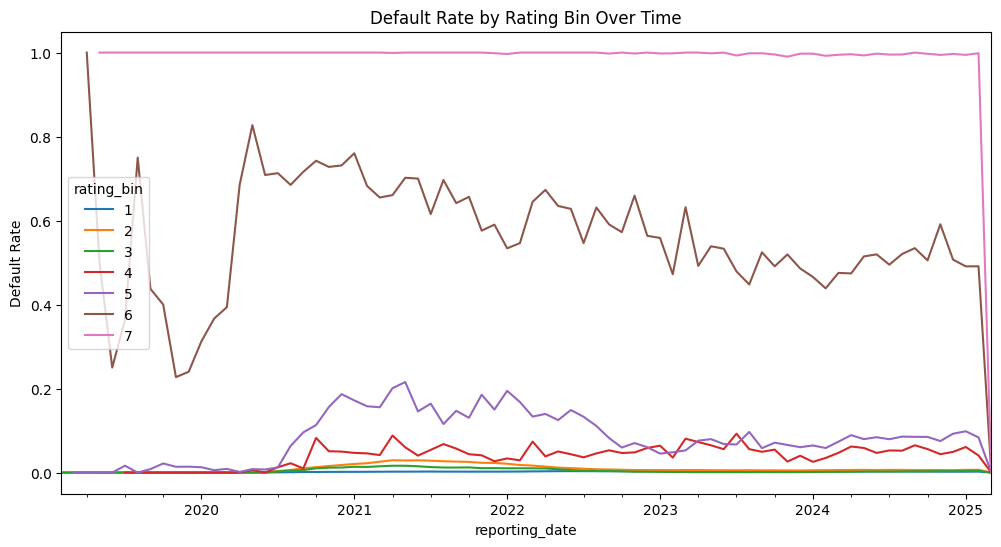

In [12]:
sample_df, bin_edges = stable_binning(
    sample_df,
    score_col='score',
    target_col='into_default_flag',
    date_col='reporting_date',
    min_grades=7,
    min_bin_size=10000,
    random_state=42
)

In [13]:
df_filtered['rating'] = pd.cut(df_filtered['score'], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)

C:\Users\jacek\AppData\Local\Temp\ipykernel_6052\1042216383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = pd.cut(df_filtered['score'], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)


In [14]:
required_columns = [
    'facility_id',           # Unique identifier for each mortgage (map to Loan_Sequence_Number)
    'observation_date',      # The month of the observation (map to reporting_date)
    'exposure',              # Outstanding principal amount (map to Current_Actual_UPB)
    'rating',                # Assigned credit rating for that month (already present)
    'score',                 # Risk score (already present)
    'default_flag',          # Flag indicating if the facility is in default (already present)
    'into_default_flag'      # Forward-looking flag for default within next 12 months (already present)
]

# Mapping to df_filtered columns:
column_mapping = {
    'facility_id': 'Loan_Sequence_Number',
    'observation_date': 'reporting_date',
    'exposure': 'Current_Actual_UPB',
    'rating': 'rating',
    'score': 'score',
    'default_flag': 'default_flag',
    'into_default_flag': 'into_default_flag'
}
df_filtered = df_filtered[[column_mapping[col] for col in required_columns]]

In [18]:
score_to_rating_bounds = {
    str(i+1): bin_edges[i+1] for i in range(len(bin_edges)-1)
}

In [25]:
df_filtered.to_csv('../data/sample_portfolio_data_fm.csv', index=False)

In [26]:
score_to_rating_bounds

{'1': np.float64(0.003613294451497495),
 '2': np.float64(0.005780360195785761),
 '3': np.float64(0.03225071728229523),
 '4': np.float64(0.039578670635819435),
 '5': np.float64(0.256146103143692),
 '6': np.float64(0.7653337121009827),
 '7': inf}